<a href="https://colab.research.google.com/github/Mirnada/Covid_19/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos dados do Covid_19


## Montando o Drive

In [68]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importando bibliotecas

In [85]:
import pandas as pd
from unicodedata import normalize
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/content/drive/My Drive/Datasets/dados-curso-completo.csv')

## Dataset original - Estatísticas

### Informações gerias do dataset

In [70]:
df.head(10)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu...,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]
5,2020-05-08 11:21:36,Marcel Silvano,marcelsilvano,"Importantes avanços! A pesquisa brasileira, a ...",4,2769,pt,Macaé,Brazil,BR,NaN,NaN,[]
6,2020-03-10 21:27:40,Teixeira Correia,LidadorNoticias,(Última hora) Volta ao Alentejo: Anulada por c...,0,39,pt,NaN,NaN,NaN,NaN,NaN,[]
7,2020-06-04 13:22:21,Thiago Moraes,ThiagoMoraesPB,João Pessoa tem queda no isolamento social por...,1,3578,pt,NaN,NaN,NaN,NaN,NaN,[]
8,2020-05-07 21:32:12,PT Brasil,ptbrasil,A #tvPT de hoje vai falar sobre a pandemia na ...,10,942696,pt,NaN,NaN,NaN,NaN,NaN,['tvPT']
9,2020-03-11 20:27:49,Niquito ;),NLazaroto,O Coronavirús causou uma pandemia e eu ainda n...,0,215,pt,NaN,NaN,NaN,NaN,NaN,[]


In [121]:
# informações gereias
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658825 entries, 0 to 1658824
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   data        1658825 non-null  object 
 1   usuario     1658768 non-null  object 
 2   apelido     1658825 non-null  object 
 3   texto       1658825 non-null  object 
 4   retweet     1658825 non-null  int64  
 5   seguidores  1658825 non-null  int64  
 6   idioma      1658825 non-null  object 
 7   lugar       74605 non-null    object 
 8   pais        74600 non-null    object 
 9   sigla       74595 non-null    object 
 10  latitude    8720 non-null     float64
 11  longitude   8720 non-null     float64
 12  hashtags    1658825 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 164.5+ MB


* data: data do tweet do usuário
* usuario: nome do usuario
* apelido: apelido do usuário
* texto: texto publicado pelo usuário
* retweet: quantidade de vezes que o tweet foi replicado
* seguidores: quantidade de seguidores do usuário
* idioma: idioma do usuário
* lugar: lugar do usuário na publicação
* pais: país do usuário na publicação
* sigla: sigla do Estado do usuário
* latitude: posição geogŕafica do usuário 
* longitude: posição geográfica do usuário

In [123]:
# quantidade de valores nulos
df.isnull().sum()

data                0
usuario            57
apelido             0
texto               0
retweet             0
seguidores          0
idioma              0
lugar         1584220
pais          1584225
sigla         1584230
latitude      1650105
longitude     1650105
hashtags            0
dtype: int64

In [125]:
df.data.describe()

count                 1658825
unique                1202322
top       2020-04-15 21:00:00
freq                       27
Name: data, dtype: object

### Analisando os dados numericos

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
retweet,1658825.0,197.853299,6337.641384,0.000000,0.000000,0.000000,0.000000,1.139763e+06
seguidores,1658825.0,32572.055193,368029.985029,0.000000,101.000000,380.000000,1470.000000,8.424125e+07
latitude,8720.0,-40.237583,20.808494,-123.120400,-47.864334,-43.955615,-38.453198,1.747893e+02
longitude,8720.0,-11.117100,19.169105,-37.818769,-23.305300,-19.624400,-7.120700,5.825778e+01


Ao gerar alguns dados estatísticos, podemos notar:

* a variável *retweet* tem como valor máximo 1139763, isso quer dizer que uma publicação específica foi replicada mais de 1 milhão de vezes, assim como a variável *seguidores* nos mostra que um determinado usuário possui aproximadamente 8,5 milhões de seguidores 

* as colunas *retweet* e *seguidores* possui uma grande discrepância em sua distribuição de frequencia. Em *retweet*, todos os valores estão acima do 3º quartil, indicando que 75% dos valores são iguais a zero.


### Analisando os dados categóricos

In [ ]:
df['sigla'].value_counts()

BR    67247
PT     2675
US     1068
IT      484
ES      379
      ...  
KR        1
AD        1
MC        1
SI        1
GF        1
Name: sigla, Length: 120, dtype: int64

Aproximadamente 90% dos dados são do Brasil

*Obs: apenas os dados que contem a sigla do país

In [ ]:
(df['sigla'].value_counts()['BR']/df['sigla'].value_counts().sum())*100

90.14947382532341

## Dataset DuvidasDB

In [148]:
duvidasDB = df[df['texto'].str.contains('?', regex=False)].copy()

# resetando o indice do dataset
duvidasDB.reset_index(drop=True, inplace=True)
# todas as letras convertidas para minúsculas
duvidasDB['texto'] = duvidasDB.texto.str.lower()
# retirada dos carecteres acentuadas por seus respectivos carecteres sem acento
duvidasDB['texto'] = duvidasDB.texto.apply(lambda txt: normalize('NFKD', txt).encode('ASCII','ignore').decode('ASCII'))
# Convertendo o tipo do campo data em datetime
duvidasDB['data'] = pd.to_datetime(duvidasDB['data'])
# Ordenando os tweets por data
duvidasDB.sort_values('data', inplace=True)
# resetando os indixes
duvidasDB.reset_index(drop=True, inplace=True)

duvidasDB.head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-01-01 23:44:49,Furacão da CCCP ☭,Dalestee13PT,@isabela_camren @__bitchcoin__ cortaram da cam...,0,1228,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-01-02 00:13:49,Teresa SM,bazert,o tamiflu nao e aquela coisa para a gripe a? u...,0,7456,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-01-02 01:33:38,"Manu, mas não a Gavassi",pringless_,@willpelicari mas como foi o processo? ele tev...,0,264,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-01-02 14:14:02,CorollaVírus.exe,CoronaVirus_exe,@senadofederal nao gostaria de fazer parte? fo...,0,68,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-01-02 16:32:53,Matheus Serdeira 🇦🇹,MathSerdeira11,brasileirao\n\nsera que vai acabar a quarenten...,0,4562,pt,NaN,NaN,NaN,NaN,NaN,[]


In [151]:
# nao podemos colocar a data como indice pois existem data iguais
duvidasDB.data.duplicated().any()

True

### Visão Geral dos Dados

In [154]:
duvidasDB.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
retweet,172501.0,123.877137,4714.103506,0.000000,0.000000,0.000000,0.000000,6.165690e+05
seguidores,172501.0,12244.941235,227150.310261,0.000000,78.000000,296.000000,1020.000000,1.310412e+07
latitude,594.0,-42.739200,16.340911,-118.291855,-48.190162,-45.280150,-38.634174,1.516286e+02
longitude,594.0,-14.001684,16.266415,-34.823600,-23.498240,-20.451828,-8.060902,5.288644e+01


Ao gerar alguns dados estatísticos, podemos notar as mesmas características do dataset original:

* a variável *retweet* tem como valor máximo 616569, isso quer dizer que uma publicação específica foi replicada mais de 0,5 milhão de vezes, assim como a variável *seguidores* nos mostra que um determinado usuário possui aproximadamente 1,3 milhão de seguidores 

* as colunas *retweet* e *seguidores* possui uma grande discrepância em sua distribuição de frequencia. Em *retweet*, todos os valores estão acima do 3º quartil, indicando que 75% dos valores são iguais a zero.


In [155]:
duvidasDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172501 entries, 0 to 172500
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   data        172501 non-null  datetime64[ns]
 1   usuario     172495 non-null  object        
 2   apelido     172501 non-null  object        
 3   texto       172501 non-null  object        
 4   retweet     172501 non-null  int64         
 5   seguidores  172501 non-null  int64         
 6   idioma      172501 non-null  object        
 7   lugar       7829 non-null    object        
 8   pais        7829 non-null    object        
 9   sigla       7829 non-null    object        
 10  latitude    594 non-null     float64       
 11  longitude   594 non-null     float64       
 12  hashtags    172501 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 17.1+ MB


In [79]:
#Contagem de dados ausentes
duvidasDB.isnull().sum()

data               0
usuario            6
apelido            0
texto              0
retweet            0
seguidores         0
idioma             0
lugar         164672
pais          164672
sigla         164672
latitude      171907
longitude     171907
hashtags           0
dtype: int64

In [81]:
# Total por pais
duvidasDB.pais.value_counts()

Brazil                        7148
Portugal                       243
United States                  101
Italy                           45
United Kingdom                  42
Spain                           34
France                          23
Canada                          22
Republic of Mozambique          21
Argentina                       17
Ireland                         12
Japan                            8
Angola                           8
Colombia                         6
Chile                            6
Germany                          5
Switzerland                      5
Belgium                          5
Peru                             4
New Zealand                      4
Bahrain                          4
India                            4
Australia                        4
Nigeria                          4
South Africa                     3
Uruguay                          3
The Netherlands                  3
Austria                          3
People's Republic of

Assim como no dataset original, o Brasil continua sendo o país do qual se tem mais registros

In [82]:
(duvidasDB['pais'].value_counts()['Brazil']/duvidasDB['pais'].value_counts().sum())*100

91.30157108187508

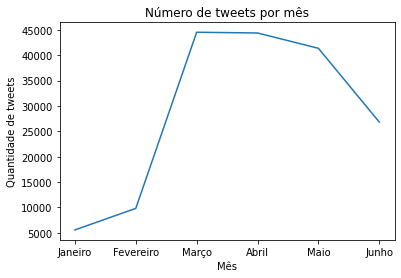

In [157]:
# perído de mais tweets
tweetMonth = duvidasDB.groupby(duvidasDB['data'].dt.month)['texto'].count()

plt.title('Número de tweets por mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de tweets')
plt.plot([month[index] for index in tweetMonth.index],tweetMonth.values)
plt.show()

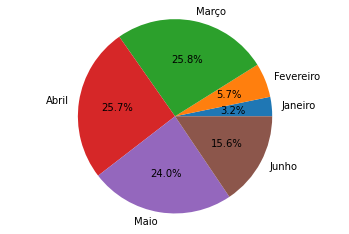

In [158]:
fig, ax = plt.subplots()
ax.pie(tweetMonth.values, labels=[month[index] for index in tweetMonth.index], autopct='%1.1f%%')
ax.axis('equal')
plt.show()

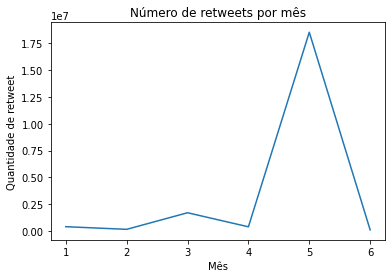

In [102]:
# período de mais retweets
retweetMonth = duvidasDB.groupby(duvidasDB['data'].dt.month)['retweet'].sum()

plt.title('Número de retweets por mês')
plt.xlabel('Mês')
plt.ylabel('Quantidade de retweet')
plt.plot(retweetMonth)

### Informações dos temas discutidos
* Doença
* Medicamentos
* Tratamentos
* Pessoas

OBS: inserir imagem de como montamos os 4 datasets

In [165]:
# lista de palavras chaves para cada título

doenca = ['covid', 'covid-19', 'covid19','coronavirus','covid_19','gripezinha','sars','epidemia', 'animais', 'transmissao', 'espiro', 'febre', 'pandemia', 'cvd', 'virus']
medicamento = ['azitromicina', 'tratamento', 'remedio','cloroquina','hidroxicloroquina','vermictina','novalgina', 'dipirona', 'dexametasona', 'azitromicina', 'corticoides']
organizacaoo = ['oms','stf','pt','pf','cnn','globo','cnnbrasil','ministério','banco','onubrasil','onu','anvisa']
pessoa = ['jair', 'bolsonaro', 'jair bolsonaro', 'jairbolsonaro','presidente','bozo','bosonaro', 'bozonaro','mandetta','trump','lula','doria','haddad','osmar terra', 'osmarterra']

In [167]:
# dataset Doença
doencaDB = duvidasDB[duvidasDB['texto'].str.contains(('|').join(doenca))].copy()
doencaDB['texto']

1         o tamiflu nao e aquela coisa para a gripe a? u...
27          @sehvnstuff h1n1? e gerar uma fucking pandemia?
30             por que sera que pandemia parou de grafitar?
39        isto ja se tornou epidemia ou pandemia? https:...
43             @chumeltorres la que?? nacademia o pandemia?
                                ...                        
172379    gente que censura descarada e essa do @youtube...
172404    meninas, a tpm e menstruacao de vcs ta afetand...
172419    a chance de eu pegar covid19 e maior a noite d...
172445    a hidroxicloroquina e a ivermectina sao excele...
172497    @marcelo69220190 @pedroernestors que coisa fei...
Name: texto, Length: 87728, dtype: object

In [74]:
# dataset Medicamento
medicDB = duvidasDB[duvidasDB['texto'].str.contains(('|').join(medicamento))].copy()
medicDB['texto']

15        @bbcbrasil @cavmota a pergunta que nao quer ca...
19        problemas no paraiso da cloroquina? e essa tre...
27        @veramagalhaes verba 792k,  fale sobre a cloro...
34        @gilmarmendes ue ?! mas a cloroquina nao recom...
39        sera que a renata vai tomar cloroquina william...
                                ...                        
172443    quais os paises estao usando cloroquina para t...
172451    @saviscos @dinhomidias @helderbarbalho nossa q...
172459    eu: mae to com a garganta inflamada desde onte...
172495    @acruz39 andas a fazer tratamentos ao coronavi...
172500    @osmarterra sr. osmar terra, gostaria de ouvir...
Name: texto, Length: 24361, dtype: object

In [75]:
# dataset Organização a partir dos datasets Doença e Medicamentos
orgDB_a = doencaDB[doencaDB['texto'].str.contains(('|').join(organização))].copy()

orgDB_b = medicDB[medicDB['texto'].str.contains(('|').join(organização))].copy()

# concatenação dos dois sub-datasets retirando os registros duplicados
orgDB = pd.concat([orgDB_a, orgDB_b]).drop_duplicates()
orgDB['texto']

42        @amorimvivian_ giiiiii ??? ta se cuidando dire...
44        @cnnbrasil so a cloroquina ja derruba os dois ...
156       #isolamento e #coronavirus? rock master #388: ...
202       @cnnbrasil o que a oms fez para combater a cov...
219       @carlosflira @cnnbrasil que guerra ? no brasil...
                                ...                        
172235    @ailtonbenedito cloroquina:e agora, globo? e a...
172264    @cleusadamascen3 @caveiro8 @jornaloglobo a cul...
172371    @andrezamatais @estadao entao o bolsonaro ta c...
172380    o tratamento com a cloroquina esta sendo utili...
172383    @katiaabreu mas voce vai da cloroquina pra teu...
Name: texto, Length: 5965, dtype: object

In [76]:
# dataset Pessoas a partir dos datasets Doença e Medicamentos
pessoaDB_a = doencaDB[doencaDB['texto'].str.contains(('|').join(pessoa))].copy()

pessoaDB_b = medicDB[medicDB['texto'].str.contains(('|').join(pessoa))].copy()

# concatenação dos dois sub-datasets retirando os registros duplicados
pessoaDB = pd.concat([pessoaDB_a, pessoaDB_b]).drop_duplicates()
pessoaDB['texto']

0         @bolsonarosp cade o fundao deputado??? congres...
13        cade aquela policia do doria que prendia velho...
16        voce iria na festa de aniversario de @jairbols...
44        @cnnbrasil so a cloroquina ja derruba os dois ...
151       @lhmandetta \nministro,\n...sabe p gentileza s...
                                ...                        
172335    @capllonchelisa @danielpmerj @jairbolsonaro o ...
172371    @andrezamatais @estadao entao o bolsonaro ta c...
172391    trump iniciando tratamento em massa amanha com...
172418    @sensoinc @bolsonarosp @oliver_talk e por nao ...
172442    @jairbolsonaro voce fez? vai assumir que esta ...
Name: texto, Length: 14275, dtype: object

In [168]:
# concatenação dos dois sub-datasets retirando os registros duplicados
covidDB = pd.concat([doencaDB, medicDB]).drop_duplicates()
covidDB['texto']

1         o tamiflu nao e aquela coisa para a gripe a? u...
27          @sehvnstuff h1n1? e gerar uma fucking pandemia?
30             por que sera que pandemia parou de grafitar?
39        isto ja se tornou epidemia ou pandemia? https:...
43             @chumeltorres la que?? nacademia o pandemia?
                                ...                        
172422    @edpazuello ministro @edpazuello ouvi boatos q...
172425    mais essa tal de cloroquina nao e aquela que m...
172442    @jairbolsonaro voce fez? vai assumir que esta ...
172443    quais os paises estao usando cloroquina para t...
172451    @saviscos @dinhomidias @helderbarbalho nossa q...
Name: texto, Length: 108787, dtype: object

In [169]:
# Usuario mais influente
covidDB[covidDB.seguidores == covidDB['seguidores'].max()]

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
157484,2020-06-05 12:00:00,G1,g1,#oassunto - o que a ciencia ja sabe sobre o us...,4,11545512,pt,NaN,NaN,NaN,NaN,NaN,['OAssunto']


In [179]:
# O Usuario com o texto mais retweet
s = covidDB[covidDB.retweet == covidDB['retweet'].max()].texto
s.values[0]

'rt @ojenabosi: this virus is on the campaign trail of a lifetime. lowering airline and gas prices?giving people paid leave from work? makin...'